In [5]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import wave
import webrtcvad
import torch
from jupyterplot import ProgressPlot
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
torch.set_num_threads(1)
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"

plt.rcParams['figure.dpi'] = 300

Sample Rate: 16000 Hz


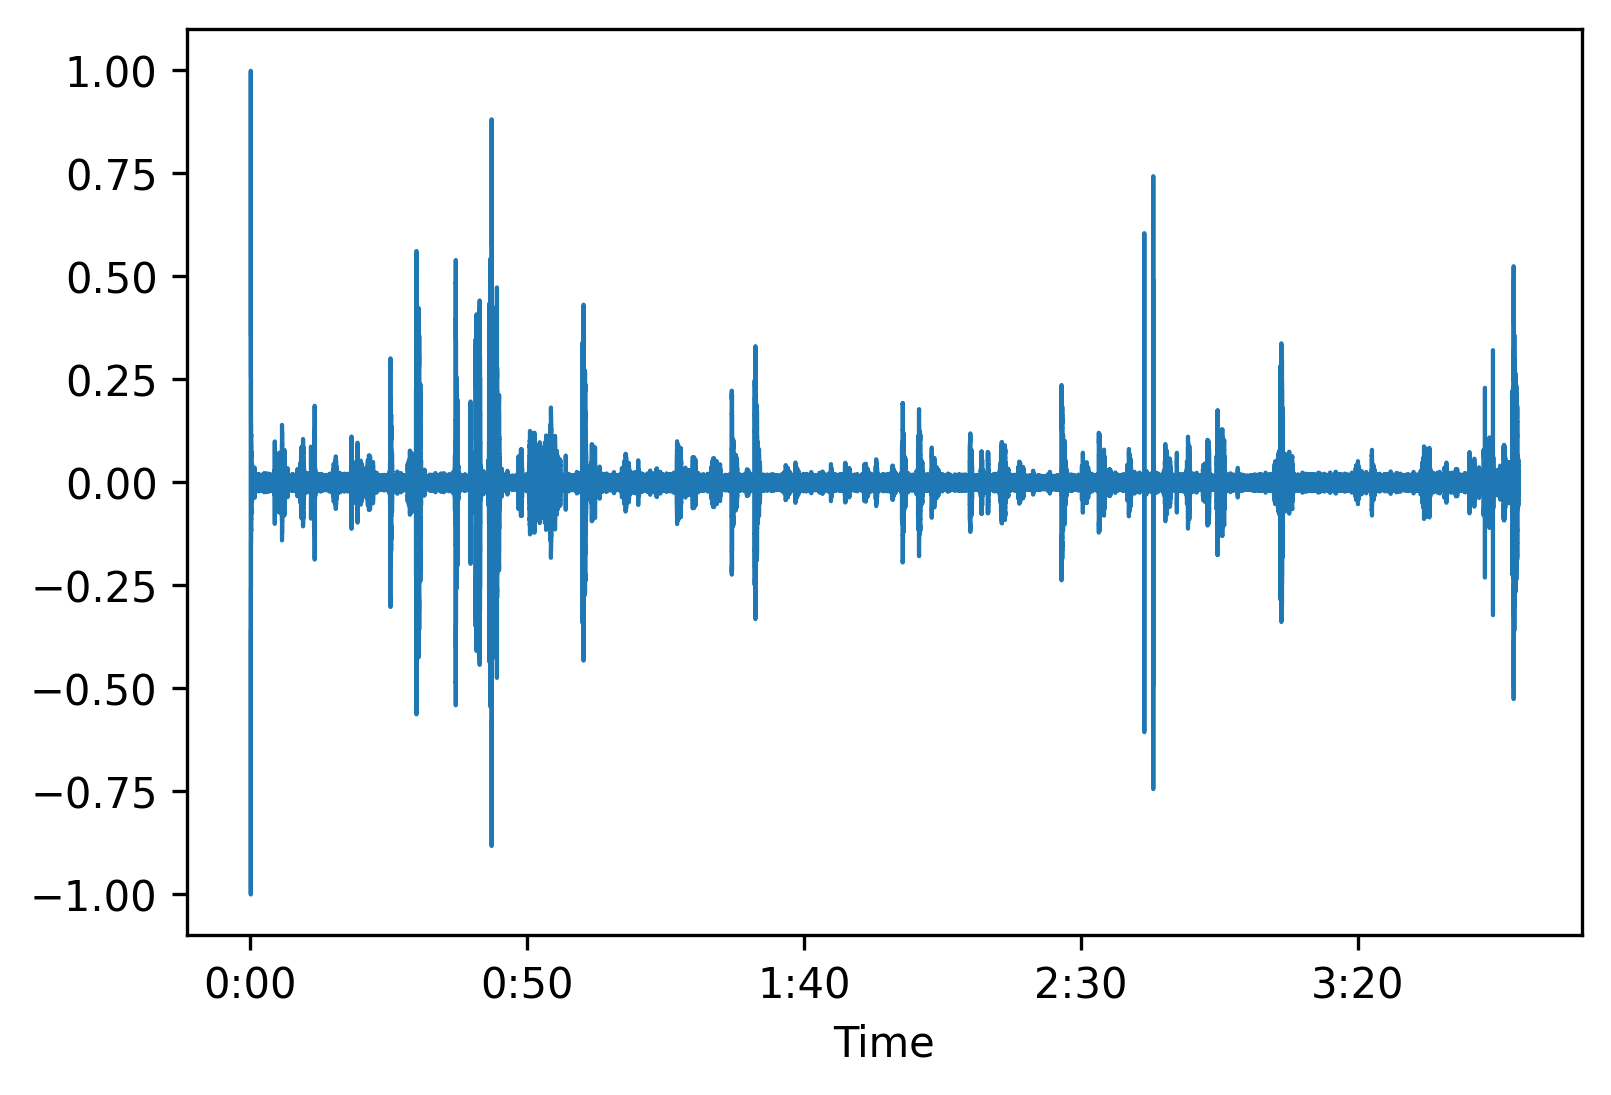

In [335]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01M_impro02.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [347]:
all_voiced_times = []
male_voiced_times = []
female_voiced_times = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01M_impro02.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            if 'M' == args[3][-4]:
                male_voiced_times.append((float(args[0][1:]), float(args[2][:-1])))
            else:
                female_voiced_times.append((float(args[0][1:]), float(args[2][:-1])))
            all_voiced_times.append((float(args[0][1:]), float(args[2][:-1])))
all_voiced_times.sort(key=lambda x: x[0])

In [350]:
# These have both female and male actors speech times
print(f"Number of separate actors voice segments: {len(all_voiced_times)}")
print(all_voiced_times)

Number of separate actors voice segments: 48
[(4.5582, 7.86), (8.0737, 11.47), (13.76, 17.52), (19.33, 23.63), (24.15, 26.98), (27.11, 29.825), (29.35, 32.46), (35.4, 38.6), (38.61, 41.33), (40.1, 42.3725), (42.4225, 44.35), (42.495, 45.82), (47.19, 49.63), (49.66, 58.18), (53.495, 54.995), (58.98, 62.11), (66.16, 70.18), (75.73, 78.6525), (78.48, 79.745), (79.18, 81.86), (82.09, 86.28), (85.84, 89.14), (88.825, 90.655), (90.39, 93.65), (95.45, 99.875), (106.1, 114.44), (115.0275, 117.31), (116.89, 122.52), (122.03, 126.42), (128.83, 131.1175), (131.06, 137.74), (137.75, 140.94), (144.54, 148.6), (149.06, 152.58), (152.31, 154.9183), (154.43, 156.51), (157.42, 160.11), (163.8, 167.56), (167.91, 170.77), (170.94, 173.01), (172.41, 177.35), (183.77, 189.08), (185.54, 190.36), (198.55, 201.28), (201.7575, 204.05), (209.95, 214.81), (214.59, 217.04), (216.925, 219.13)]


In [362]:
# Here we have both female and male actors speech times combined
# while not allowing differences between segments to be inferior than 1 second
min_segment_duration = 1 # duration in seconds

combined_voiced_times = []
prev_start, prev_end = all_voiced_times[0]
for start, end in all_voiced_times[1:]:
    if start - prev_end <= min_segment_duration:
        prev_end = end
    else:
        combined_voiced_times.append((prev_start, prev_end))
        prev_start, prev_end = start, end
combined_voiced_times.append((prev_start, prev_end))
combined_voiced_times.sort(key=lambda x: x[0])
print(f"Number of combined actors voice segments: {len(combined_voiced_times)}")
print(combined_voiced_times)

Number of combined actors voice segments: 16
[(4.5582, 11.47), (13.76, 17.52), (19.33, 32.46), (35.4, 45.82), (47.19, 54.995), (58.98, 62.11), (66.16, 70.18), (75.73, 93.65), (95.45, 99.875), (106.1, 126.42), (128.83, 140.94), (144.54, 160.11), (163.8, 177.35), (183.77, 190.36), (198.55, 204.05), (209.95, 219.13)]


In [353]:
def display_graph(ax, title, data, legend_cols=3):
    ax.set_title(title)
    y_len = np.max(y) * 0.02
    y_space = np.max(y) * 0.1
    upper_y, middle_y, lower_y = np.max(y)+ y_space + y_len*3, np.max(y)+ y_space + y_len*2, np.max(y)+ y_space + y_len
    librosa.display.waveshow(y, sr=sr, label="Audio Waveform")
    start, end = data[0]
    ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r', label="Voice Segment Time")
    ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    for start, end in data[1:]:
        ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r')
        ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
        ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
        ncol=legend_cols, fancybox=True, shadow=True)

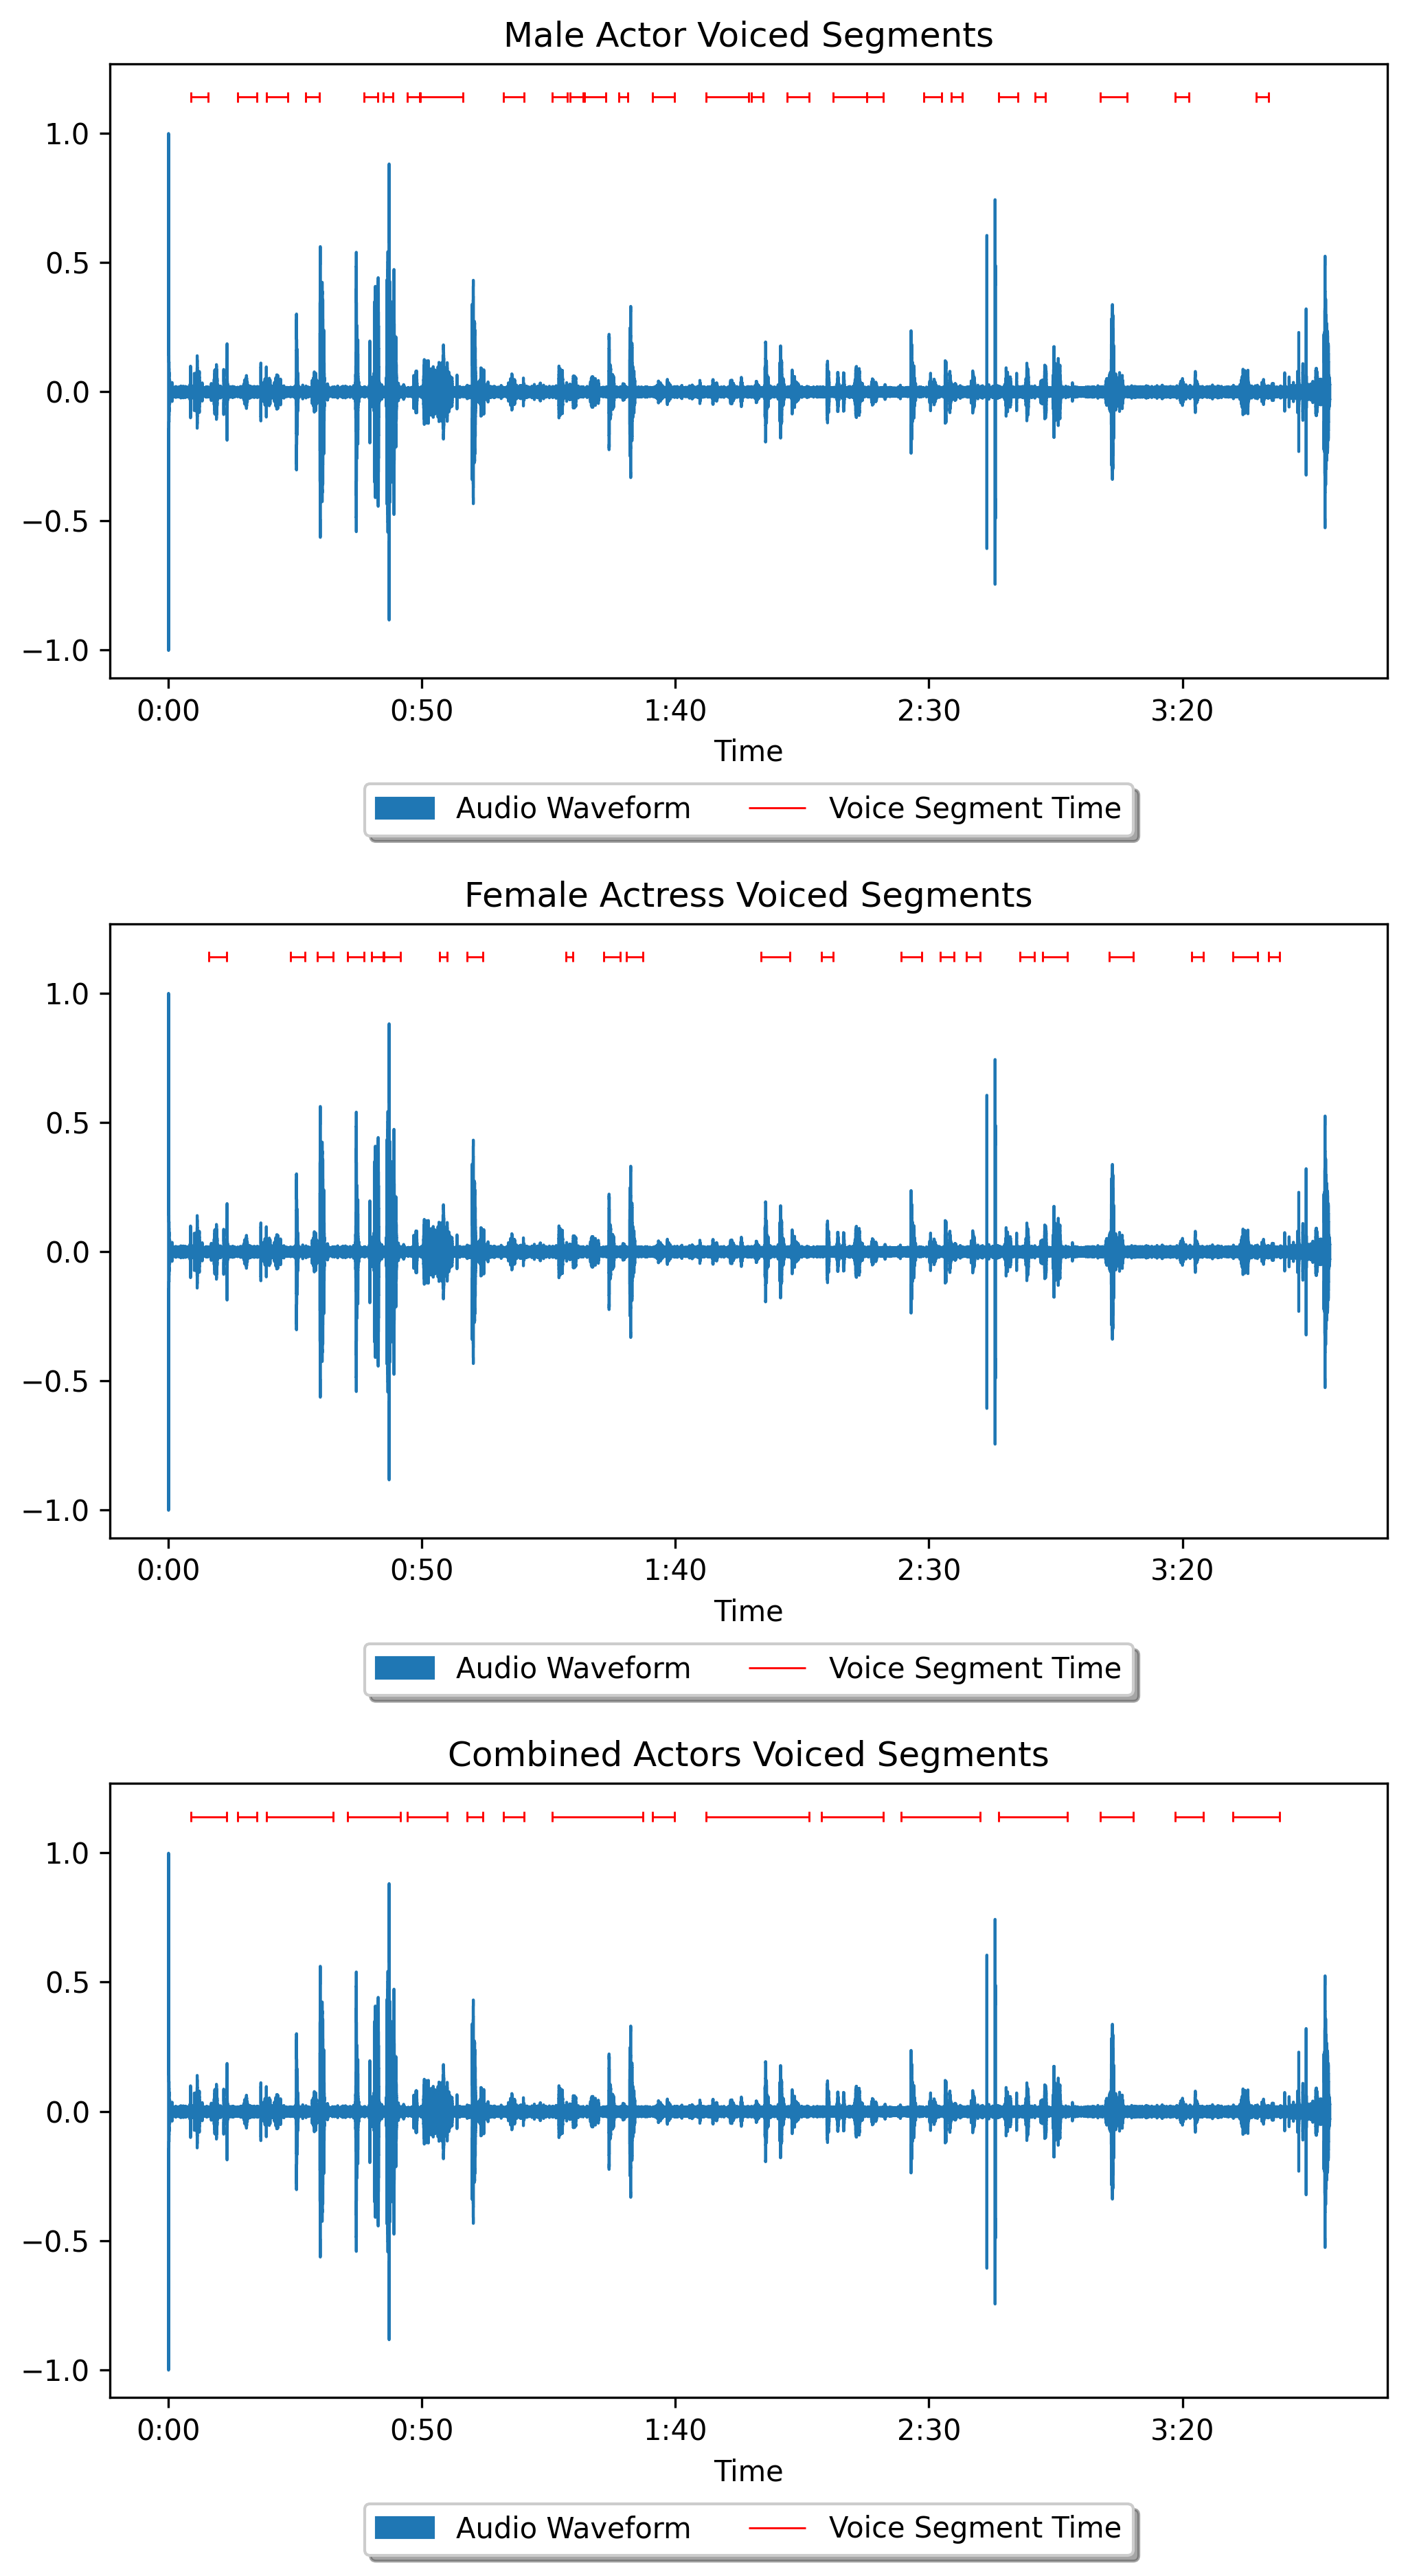

In [354]:
grid = plt.GridSpec(3, 1, wspace=.1, hspace=.4)
plt.figure(figsize=(8, 15))

display_graph(plt.subplot(grid[0, 0]), "Male Actor Voiced Segments", male_voiced_times)
display_graph(plt.subplot(grid[1, 0]), "Female Actress Voiced Segments", female_voiced_times)
display_graph(plt.subplot(grid[2, 0]), "Combined Actors Voiced Segments", combined_voiced_times)

plt.show()

# Framing

In [355]:
def read_wav_part_from_local(path: str, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        fs = wavread.getframerate()
        start = int(start_s * fs)
        duration = int(duration_s * fs)
        wavread.setpos(start)
        wav_bytes = wavread.readframes(duration)

        if wavread.getsampwidth() == 2:
            dtype = 'int16'
        elif wavread.getsampwidth() == 4:
            dtype = 'int32'
        else:
            raise NotImplemented('Error Reading Sample')

        wav_array = np.frombuffer(wav_bytes, dtype=dtype)
        return wav_array, fs

In [356]:
def int2float32(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/abs_max
    sound = sound.squeeze()
    return sound

model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

silero_voiced_times = []
silero_confidences = []

step = .1 # duration in seconds
min_confidence = .7
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

    silero_confidences.append(confidence)
    
    pp.update(confidence)

    end = start+step

    if confidence >= min_confidence:
        if prev_start == None:
            prev_start, prev_end = start, end
        elif prev_end == start or start - prev_end <= min_segment_duration:
            prev_end = end
        else:
            if prev_end - prev_start >= min_segment_duration:
                silero_voiced_times.append((prev_start, prev_end))
            prev_start, prev_end = start, end

if (len(silero_voiced_times) and silero_voiced_times[-1] != (prev_start, prev_end)) or ((not len(silero_voiced_times)) and prev_end):
    if prev_end - prev_start > min_segment_duration:
        silero_voiced_times.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


<IPython.core.display.Javascript object>

In [357]:
print(f"Number of voice segments: {len(silero_voiced_times)}")
print(silero_voiced_times)

Number of voice segments: 28
[(1.1, 4.6), (8.700000000000001, 10.1), (17.5, 19.700000000000003), (21.900000000000002, 22.900000000000002), (25.700000000000003, 27.500000000000004), (29.900000000000002, 31.400000000000002), (32.5, 34.1), (40.1, 41.800000000000004), (43.7, 45.2), (53.1, 62.1), (65.60000000000001, 68.5), (69.9, 71.5), (79.60000000000001, 80.8), (82.5, 84.4), (94.2, 95.4), (96.60000000000001, 101.9), (108.30000000000001, 110.8), (129.6, 131.5), (142.70000000000002, 146.4), (162.10000000000002, 165.9), (167.20000000000002, 168.20000000000002), (173.20000000000002, 185.9), (187.60000000000002, 199.5), (200.8, 202.3), (205.10000000000002, 211.4), (216.60000000000002, 220.5), (222.60000000000002, 225.20000000000002), (227.4, 229.1)]


In [372]:
# medium strict mode
vad = webrtcvad.Vad(2)

pp = ProgressPlot(plot_names=["WebRTCVAD"], line_names=["speech probabilities"], x_label="audio chunks")

webrtcvad_voiced_times = []
webrtcvad_confidences = []

step = .01 # duration in seconds
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    if webrtcvad.valid_rate_and_frame_length(fs, len(wav_array)):
        confidence = vad.is_speech(wav_array, fs)
        webrtcvad_confidences.append(confidence)

        pp.update(confidence)

        end = start+step

        if confidence == 1:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_segment_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_segment_duration:
                    webrtcvad_voiced_times.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(webrtcvad_voiced_times) and webrtcvad_voiced_times[-1] != (prev_start, prev_end)) or ((not len(webrtcvad_voiced_times)) and prev_end):
    if prev_end - prev_start >= min_segment_duration:
        webrtcvad_voiced_times.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

In [373]:
print(f"Number of voice segments: {len(webrtcvad_voiced_times)}")
print(webrtcvad_voiced_times)

Number of voice segments: 30
[(4.34, 6.33), (8.43, 9.74), (14.75, 16.770000000000003), (18.2, 22.290000000000003), (25.080000000000002, 27.220000000000002), (28.310000000000002, 31.42), (39.45, 45.25), (50.26, 56.949999999999996), (59.800000000000004, 63.14), (66.87, 68.42), (76.38, 80.5), (83.18, 84.96000000000001), (86.81, 87.95), (89.60000000000001, 92.05000000000001), (96.59, 99.05000000000001), (110.63, 111.63000000000001), (117.59, 118.80000000000001), (122.86, 123.88000000000001), (131.78, 136.79999999999998), (146.37, 147.42), (150.02, 155.23999999999998), (164.79, 166.15), (168.89000000000001, 170.32999999999998), (171.95000000000002, 173.18), (174.4, 176.0), (184.16, 188.26), (199.52, 203.01), (211.56, 213.01), (215.47, 218.14), (219.21, 229.03)]


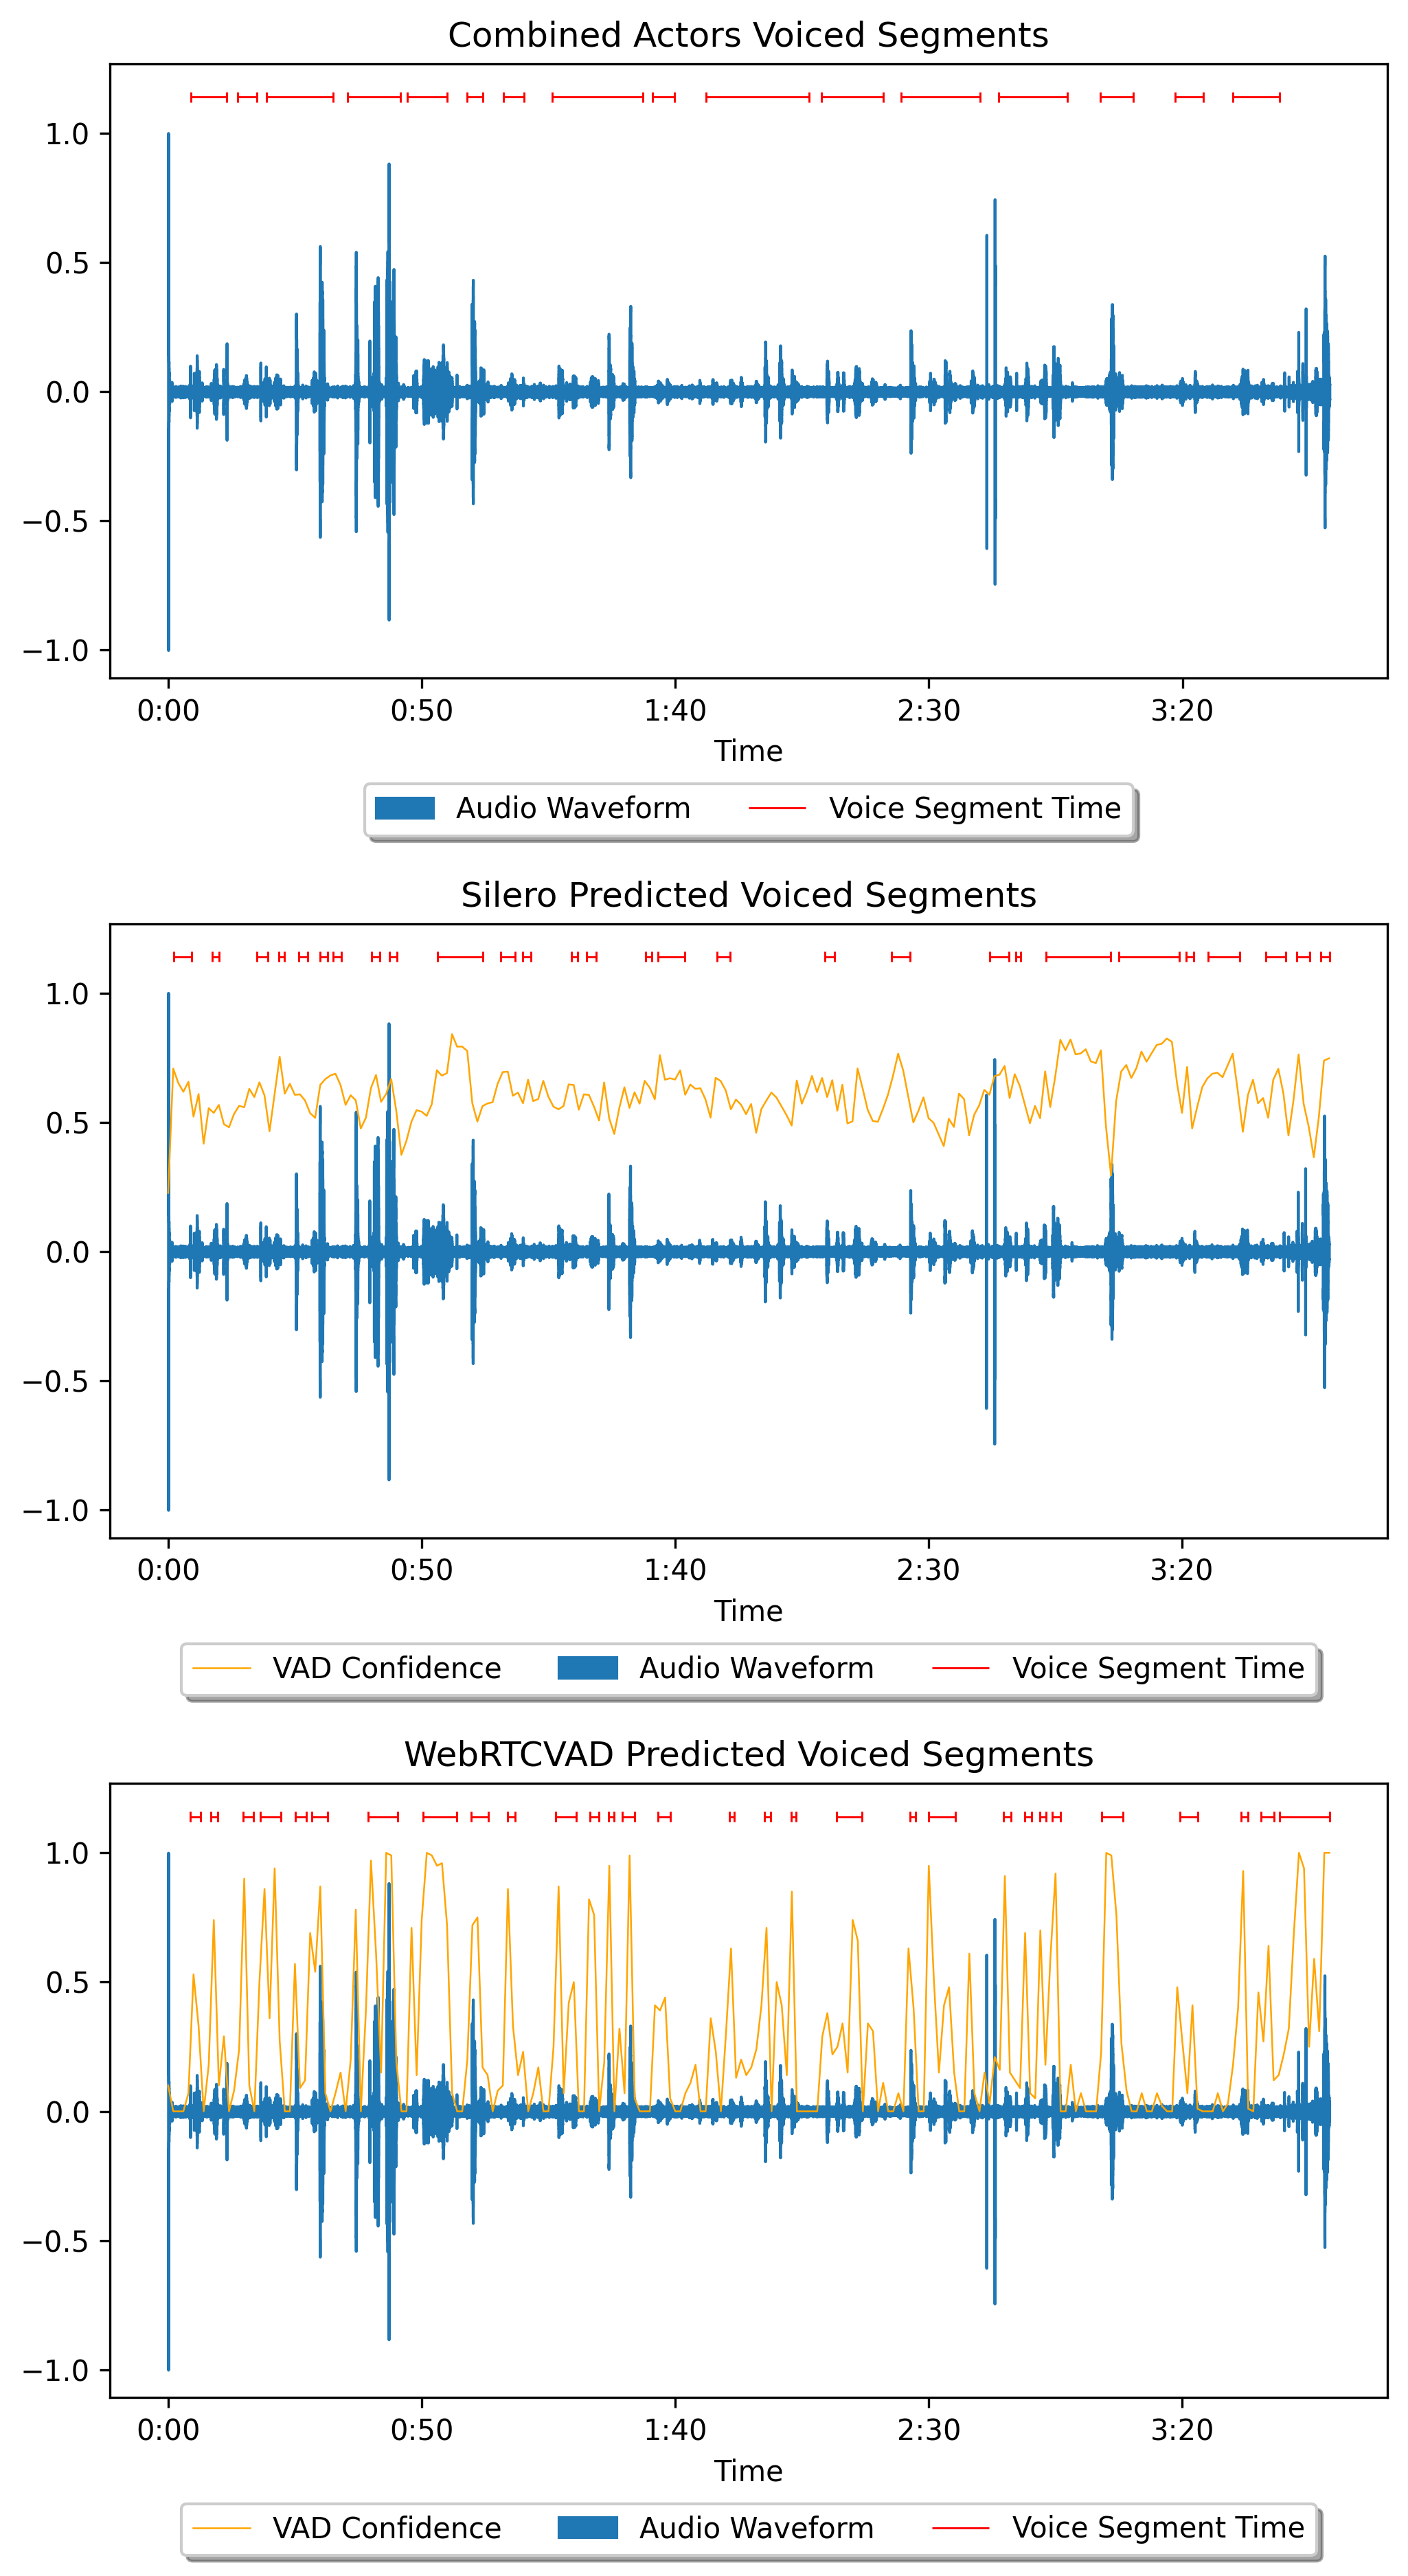

In [374]:
grid = plt.GridSpec(3, 1, wspace=.1, hspace=.4)
plt.figure(figsize=(8, 15))

display_graph(plt.subplot(grid[0, 0]), "Combined Actors Voiced Segments", combined_voiced_times)

ax = plt.subplot(grid[1, 0])
plt_confidences = []
for i in range(0, len(silero_confidences), 10):
    plt_confidences.append(np.mean(silero_confidences[i:i+10]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced Segments", silero_voiced_times, 4)


ax = plt.subplot(grid[2, 0])
plt_confidences = []
for i in range(0, len(webrtcvad_confidences), 100):
    plt_confidences.append(np.mean(webrtcvad_confidences[i:i+100]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "WebRTCVAD Predicted Voiced Segments", webrtcvad_voiced_times, 4)

plt.show()

In [378]:
Audio(y[int(silero_voiced_times[7][0]*sr):int(silero_voiced_times[7][1]*sr)], sr)

In [380]:
Audio(y[int(silero_voiced_times[8][0]*sr):int(silero_voiced_times[8][1]*sr)], sr)

In [379]:
Audio(y[int(webrtcvad_voiced_times[6][0]*sr):int(webrtcvad_voiced_times[6][1]*sr)], sr)